In [1]:
# Imports
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample

from mltools import classification_tools as CT
from mltools import model_tools as MT

# EDA

In [2]:
# Import dataset
df = pd.read_csv('Diabetes.csv', sep=';')
df.head()

,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# Missing values
df.info()
# No missing values

In [ ]:
# Plot data and outliers
df.describe()

In [ ]:
# Continious variables plot. Most of them are skewed. Bodymassindex may be normal (with more data we would be more confident)
df.drop(['PREGNANT', 'DIABETES'], axis=1).hist(figsize=(10,10))
plt.show()

In [ ]:
# Discrete variables plot. Pregnant variable is skewed. We can see an unbalance in the diabetes variable.
df['PREGNANT'].value_counts().sort_index().plot.bar()
plt.show()
df['DIABETES'].value_counts().sort_index().plot.bar()
plt.show()

In [ ]:
df.plot.box(subplots=True, layout=(3, 3), sharex=False, sharey=False, figsize=(10,10))
plt.show()
# Outliers can be observed (not all of them, this is just a proyection in 1 dimension)

In [3]:
# Encode categorical values
df.DIABETES = df.DIABETES.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PREGNANT       768 non-null    int64   
 1   GLUCOSE        768 non-null    int64   
 2   BLOODPRESS     768 non-null    int64   
 3   SKINTHICKNESS  768 non-null    int64   
 4   INSULIN        768 non-null    int64   
 5   BODYMASSINDEX  768 non-null    float64 
 6   PEDIGREEFUNC   768 non-null    float64 
 7   AGE            768 non-null    int64   
 8   DIABETES       768 non-null    category
dtypes: category(1), float64(2), int64(6)
memory usage: 49.0 KB


In [ ]:
# Analyze continious variables

# Pairplot 
sns.pairplot(df, hue = 'DIABETES')
plt.show()
sns.pairplot(df)
plt.show()
# It can be observed some skewed variables, they can be normalized.

In [4]:
# Data engenieering from the pairplot
# Glucose around 100 in one of the categories
df['DISG'] = (df['GLUCOSE'] - 100) ** 2

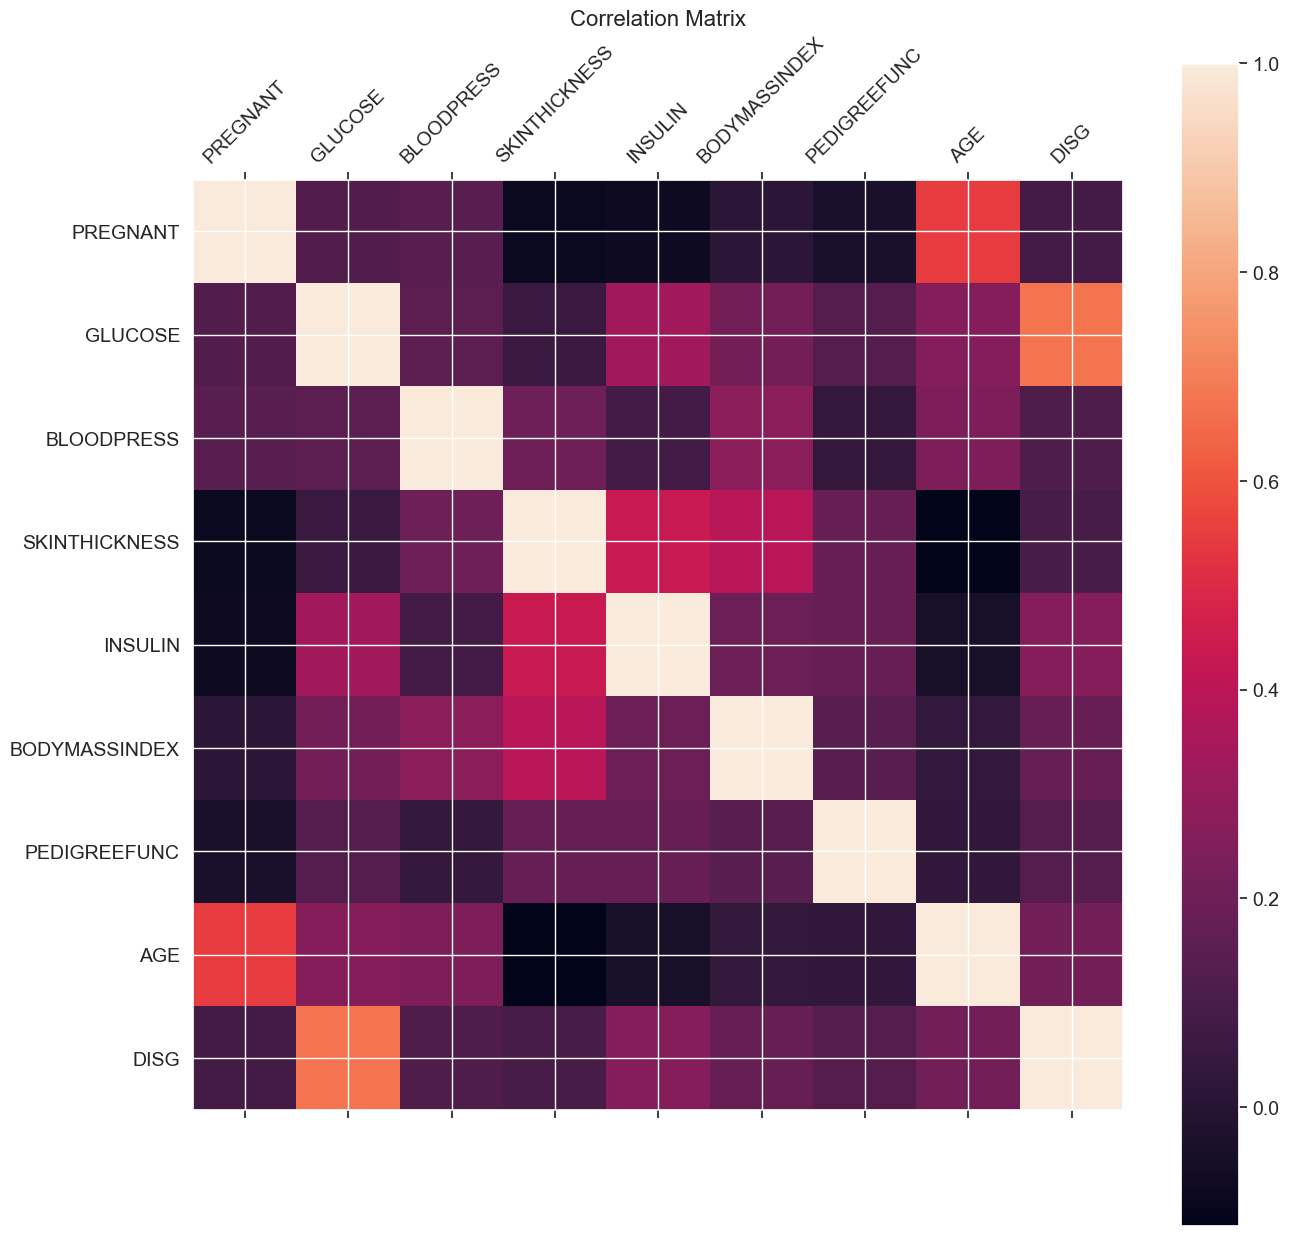

In [5]:
# Correlation plot
#correlation plot of numeric variables
f = plt.figure(figsize=(15,15))
plt.matshow(df.select_dtypes(include=['int64','float64']).corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(include=['int64','float64']).shape[1]), df.select_dtypes(include=['int64','float64']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(include=['int64','float64']).shape[1]), df.select_dtypes(include=['int64','float64']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()
# By looking at the plot, there are no many variables correlated. The ones witch are more correlated are Age, pregnant and DisG, glucose (DisG calculated using glucose)

In [6]:
# Class imbalance
print(df['DIABETES'].value_counts())
# As we can see, class number 0 has double of rows than class number 1 (down-sampling or up-sampling could be used)

# Down-sampling
dw = resample(df.loc[df.DIABETES == 0, :], replace=False, n_samples=400, random_state=2022)

# Up-sampling
up = resample(df.loc[df.DIABETES == 1, :], replace=True, n_samples=400, random_state=2022)

# Balanced dataset
df = pd.concat([dw, up])

df.DIABETES.value_counts()

0    500
1    268
Name: DIABETES, dtype: int64


0    400
1    400
Name: DIABETES, dtype: int64

In [7]:
# Train test split

# Define input and output matrices
INPUTS = list(df.columns)
OUTPUT = 'DIABETES'
INPUTS.remove(OUTPUT)
X = df[INPUTS]
y = df[OUTPUT]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)  

 # Logistic Regression

In [8]:
## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['Y'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['Y'] = y_test

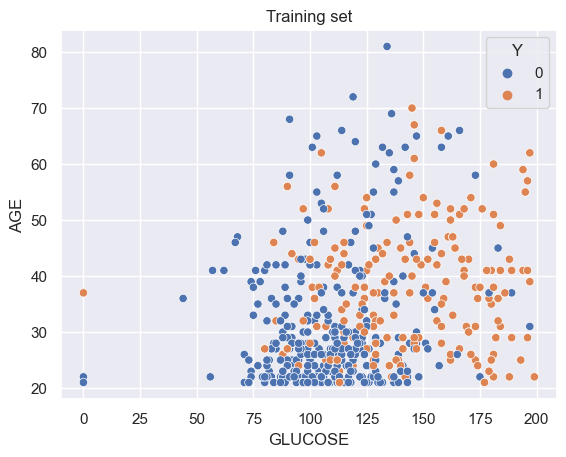

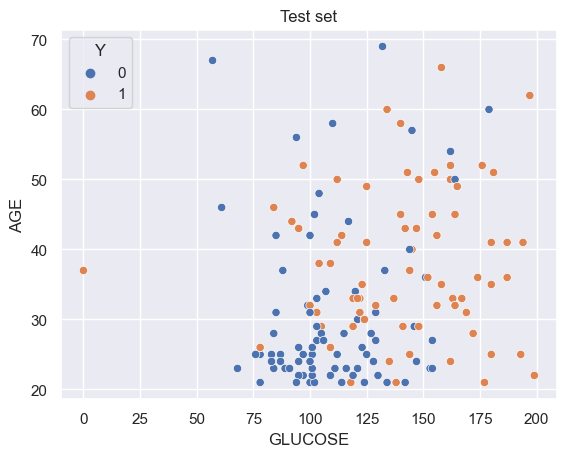

In [9]:
## plot training and test sets. 
# Plot glucose over age. They follow the same distribution in train and test. 

# Train plot
palette = {0:'C0', 1:'C1'} # Color palette 
sns.scatterplot(x = 'GLUCOSE', y = 'AGE', hue = 'Y', data = dfTR_eval, palette=palette).set_title("Training set")
plt.show()

# Test plot
plt.figure()
sns.scatterplot(x = 'GLUCOSE', y = 'AGE', hue = 'Y', data = dfTS_eval, palette=palette).set_title("Test set")
plt.show()

In [10]:
# Input setting

# Remove this varivable from the numeric input (they will be polynomial)
INPUTS.remove('AGE')
INPUTS.remove('GLUCOSE')

# Set diferent types of inputs
INPUTS_LR_NUM =  INPUTS
INPUTS_LR_SQ = ['AGE', 'GLUCOSE']
INPUTS_LR_CAT = []
INPUTS_LR = INPUTS_LR_NUM + INPUTS_LR_SQ + INPUTS_LR_CAT

# Prepare the numeric variables by scaling
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the quadratic variables by scaling and transforming into a 2 degree polynomial
square_transformer = Pipeline(steps=[('scaler', StandardScaler()),
                                      ('Poly',PolynomialFeatures())])

# Prepare the categorical variables by encoding the categories (No categorical variables)
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_LR_NUM),
        ('sq', square_transformer, INPUTS_LR_SQ),
        ('cat', categorical_transformer, INPUTS_LR_CAT)
        ])

# Create model
LogReg_fit = Pipeline(steps=[('Prep',preprocessor), # Preprocess the variables when training the model 
                        ('LogReg',LogisticRegression(random_state=2022))]) # Model to use in the pipeline
#Train model
LogReg_fit.fit(X_train[INPUTS_LR], y_train)

print("Logistic Regression Trained")

Logistic Regression Trained


In [12]:
# Obtain Cross-Validation accuracy
print("CV accuracy is")
print(cross_val_score(LogReg_fit, X_train[INPUTS_LR], y_train, cv=10, scoring='accuracy').mean())

CV accuracy is
0.7828125


In [13]:
# Regression summary
CT.summaryLogReg(LogReg_fit, X_train[INPUTS_LR], y_train)
# We can see the estimated values for the variables defined. We can see another measures asociated with them.
# PEDIGREEFUNC, BODYMASSINDEX, DISG, AGE, GLUCOSE and AGE**2 are the most significant variables.  

Deviance Residuals:
        Min        1Q    Median        3Q       Max
0 -0.992595 -0.215503  0.000216  0.199474  0.920447

Coefficients:
               Estimate
Intercept      0.637096
PREGNANT       0.231122
BLOODPRESS    -0.294771
SKINTHICKNESS  0.110969
INSULIN       -0.176475
BODYMASSINDEX  0.624508
PEDIGREEFUNC   0.447873
DISG           0.540044
1             -0.000050
AGE            0.945402
GLUCOSE        0.892703
AGE^2         -0.416970
AGE GLUCOSE   -0.173407
GLUCOSE^2     -0.162461
               Estimate      Std. Err       t-value      Pr(>|t|) Signif
Intercept      0.637096  1.710076e+07  3.725544e-08  1.000000e+00       
PREGNANT       0.231122  1.388689e-01  1.664321e+00  9.604834e-02      .
BLOODPRESS    -0.294771  1.207448e-01 -2.441274e+00  1.463553e-02      *
SKINTHICKNESS  0.110969  1.314165e-01  8.444080e-01  3.984415e-01       
INSULIN       -0.176475  1.232300e-01 -1.432079e+00  1.521213e-01       
BODYMASSINDEX  0.624508  1.326454e-01  4.708105e+00  2.500299e-

c:\Users\revue\anaconda3\envs\ml\lib\site-packages\mltools\classification_tools.py:75: RuntimeWarning: invalid value encountered in sqrt
  coefs['Std. Err'] = np.sqrt(np.diag(covLogit))


In [14]:
# Obtain a report of the model based on predictions 
dfTR_eval['Y_LR_pred'] = LogReg_fit.predict(X_train[INPUTS_LR])
dfTR_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_train[INPUTS_LR])[:,0]
dfTR_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_train[INPUTS_LR])[:,1]
# Scale test using preprocess in training
dfTS_eval['Y_LR_pred'] = LogReg_fit.predict(X_test)
dfTS_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_test[INPUTS_LR])[:,0]
dfTS_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_test[INPUTS_LR])[:,1]

#visualize evaluated data
print(dfTR_eval.head())
print(dfTS_eval.head())

     PREGNANT  GLUCOSE  BLOODPRESS  SKINTHICKNESS  INSULIN  BODYMASSINDEX  \
176         6       85          78              0        0           31.2   
104         2       85          65              0        0           39.6   
141         5      106          82             30        0           39.5   
455        14      175          62             30        0           33.6   
263         3      142          80             15        0           32.4   

     PEDIGREEFUNC  AGE  DISG  Y  Y_LR_pred  Y_LR_prob_neg  Y_LR_prob_pos  
176         0.382   42   225  0          0       0.683405       0.316595  
104         0.930   27   225  0          0       0.736193       0.263807  
141         0.286   38    36  0          1       0.441874       0.558126  
455         0.212   38  5625  1          1       0.034259       0.965741  
263         0.200   63  1764  0          1       0.425616       0.574384  
     PREGNANT  GLUCOSE  BLOODPRESS  SKINTHICKNESS  INSULIN  BODYMASSINDEX  \
290       

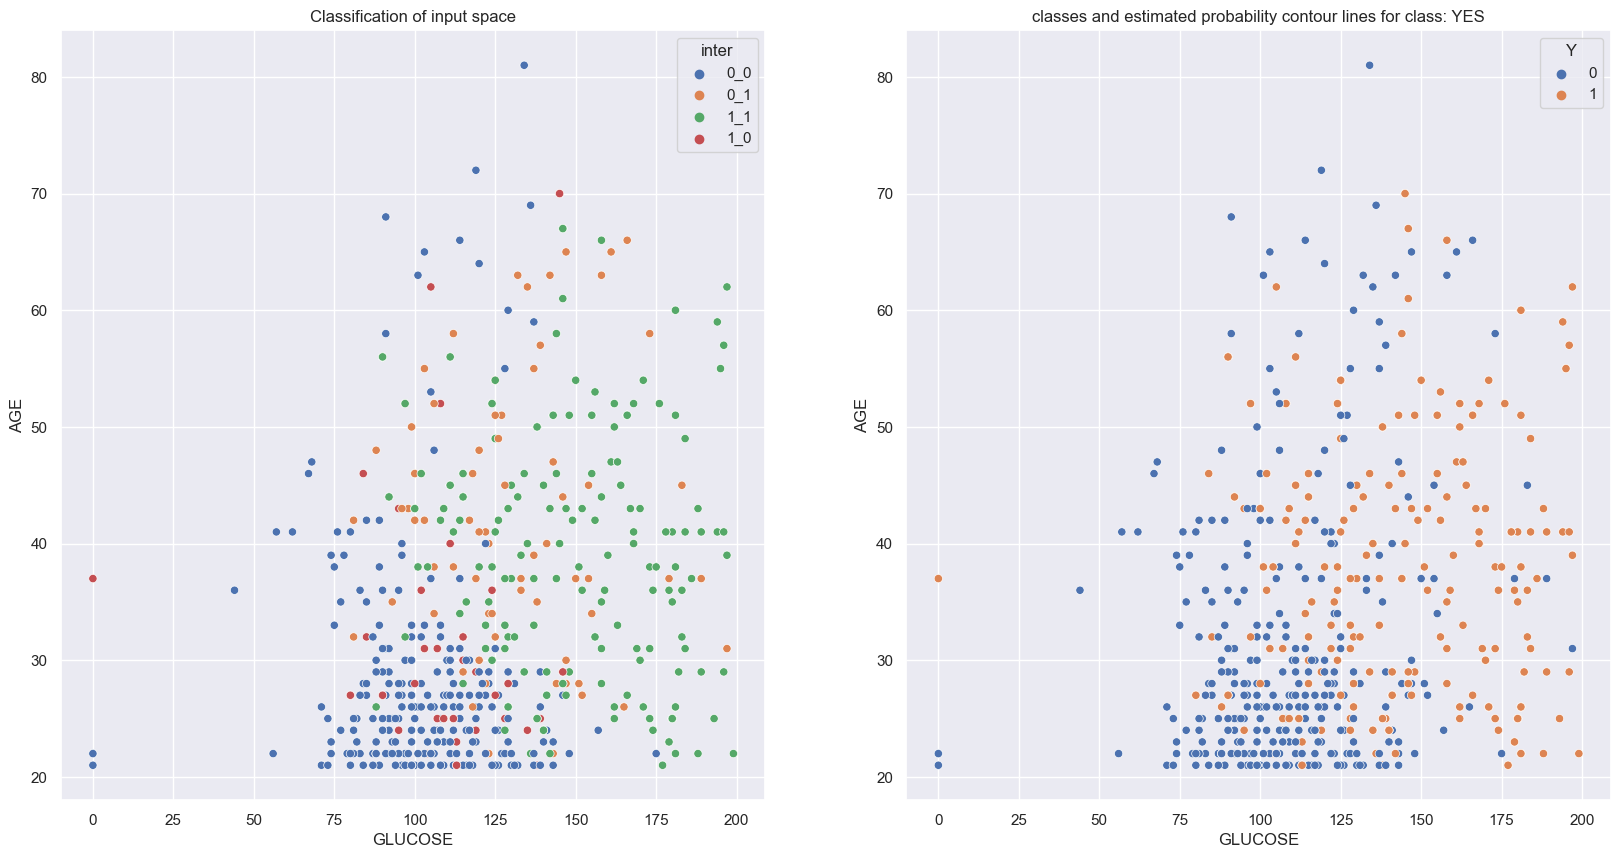

In [15]:
# Plot classification in a 2 dimensional space (Glucose x Age)
plt.figure(figsize=(20, 10))
CT.plot2DClass(X_train[INPUTS_LR], dfTR_eval['Y'], LogReg_fit, 'GLUCOSE', 'AGE', 'YES', 50) 

In [16]:
#Confusion matrix for Log Reg Model
# As a false negative is the worst scenario, we are interested in that measure
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_LR_pred'])
# 0.3 better than the NIR model
# Kappa = 0.59, closer to 1 than 0 (value expected by chance)
# Detection rate = 0.4, as there are half of each class, best situation is 0.5 and worst 0.
# Prevalence = 0.5 as expected (half of the examples were positive)
# Prevalence close to detection prevalence (total number of true values close to number of true clasifications)
# F Score cercano a 1

----- TRAINING CONFUSION MATRIX -----
Confusion Matrix and Statistics
	   Prediction
 Reference   0   1
         0 251  69
         1  62 258

Accuracy: 0.8
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.59
Mcnemar's Test P-Value: 0.6
Sensitivity: 0.81
Specificity: 0.78
Pos pred value: 0.79
Neg pred value: 0.8
Prevalence: 0.5
Detection Rate: 0.4
Detection prevalence: 0.51
Balanced accuracy: 0.8
F Score: 0.8
Positive class: 1


In [17]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_LR_pred'])

# Values obtained for the test similar to training -> Good generalization

----- TEST CONFUSION MATRIX-----
Confusion Matrix and Statistics
	   Prediction
 Reference  0  1
         0 62 18
         1 15 65

Accuracy: 0.79
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.59
Mcnemar's Test P-Value: 0.73
Sensitivity: 0.81
Specificity: 0.78
Pos pred value: 0.78
Neg pred value: 0.81
Prevalence: 0.5
Detection Rate: 0.41
Detection prevalence: 0.52
Balanced accuracy: 0.79
F Score: 0.8
Positive class: 1


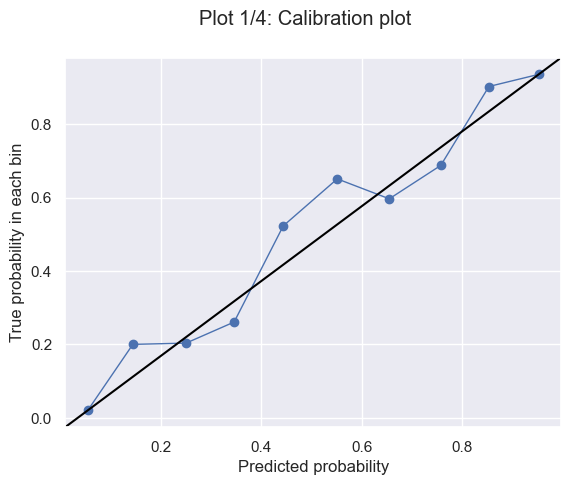

c:\Users\revue\anaconda3\envs\ml\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\revue\anaconda3\envs\ml\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


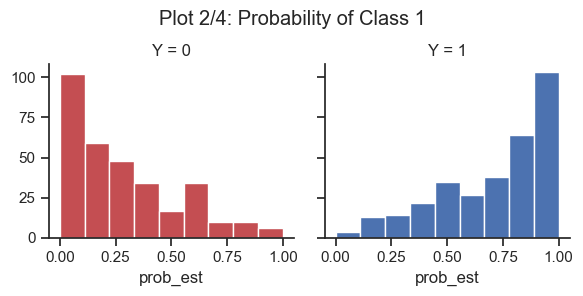

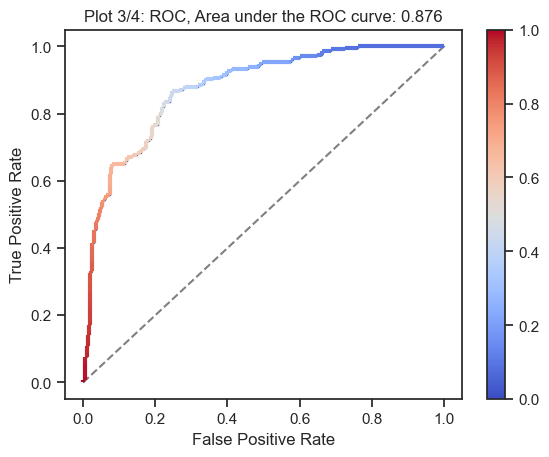

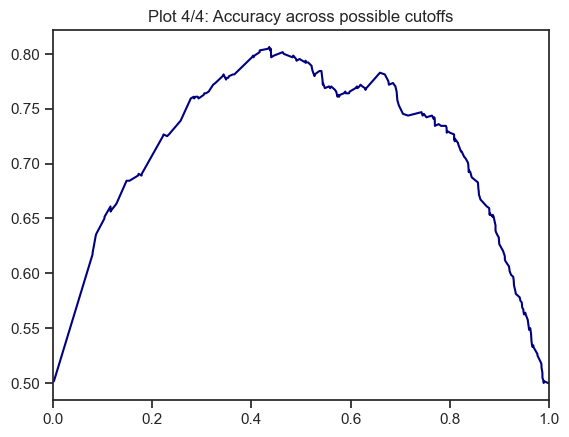

In [18]:
CT.plotClassPerformance(dfTR_eval['Y'], LogReg_fit.predict_proba(X_train[INPUTS_LR]), selClass=1)

# Calibration plot: when we assing probabilities close to 0.5, there are more real positive values (around 0.6), they should be close to 0.5 each class
# Histograms: Probabilities are condensed on the outsides, but we would like to see a more defined tendency 
# AUC: equals to 0.876, close to 1, that means our model performs well with different thresholds
# Accuracy across posible cutoffs plot shows that when the thresholds is close to 0.5 it performs the best

# KNN

In [ ]:
## Compare models
metric = 'Accuracy'
score = {'Decision Tree': cross_val_score(tree_fit, X_train[INPUTS_DT], y_train, cv=10, scoring='accuracy'), 
         'Random Forest': cross_val_score(rf_fit, X_train[INPUTS_RF], y_train, cv=10, scoring='accuracy') }
MT.dotplot(score, metric)

In [ ]:
CT.calibration_plot(y_test, dfTS_eval[['Y_DT_prob_pos','Y_RF_prob_pos']])
CT.roc_curve(y_test,dfTS_eval[['Y_DT_prob_pos','Y_RF_prob_pos']], 'YES')